# Compare permutation test to GMM

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [23]:
from statsmodels.sandbox.regression.gmm import GMM

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [8]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/'

### Perform some basic filtering

In [9]:
adata = sc.read(data_path + 'interferon.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [10]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes      5355 
B cells              2570 
CD8 T cells          2039 
NK cells             1991 
FCGR3A+ Monocytes    1592 
Dendritic cells      432  
Megakaryocytes       208  
Name: cell, dtype: int64

In [11]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


In [12]:
sc.pl.tsne(adata, color='cell_type')

In [13]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [14]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1880


### Subset CD4 T cells

In [15]:
cd4_adata = adata[adata.obs.cell == 'CD4 T cells'].copy()

### Fit permutation p values

In [33]:
estimator.beta

0.1

In [34]:
estimator.beta_sq

0.02062358872333306

In [17]:
estimator = scme.SingleCellEstimator(
    adata=adata, 
    group_label='stim',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)
estimator.estimate_parameters()

estimator.compute_confidence_intervals_1d(
    groups=estimator.groups,
    groups_to_compare=[('ctrl', 'stim')])

Computing observed moments for: ctrl
Computing observed moments for: stim
Gamma RVs generated..


### Fit GMMs

In [24]:
class MeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)
        
    
    def fitstart(self):
        
        y = self.endog.reshape(-1, 1)/self.q
        x_mat = self.exog
        ylog = np.log(y+1)
        sol, _, _, _ = np.linalg.lstsq(x_mat, ylog, rcond=-1)
        
        return sol.reshape(-1)


    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog

        beta_hat = params.reshape(-1, 1)
        
        a =  (x_mat*y)/self.q - (x_mat*np.exp(x_mat@beta_hat))
        return a
    
class VarianceGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(VarianceGMM, self).__init__(*args, **kwds)
        
        
    def fitstart(self):
        
        y = self.endog.reshape(-1, 1)/self.q
        ylog = np.log(y+1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)
        
        res = (ylog-x_mat@mean_beta)**2
        sol, _, _, _ = np.linalg.lstsq(x_mat, res, rcond=-1)
        return sol.reshape(-1)

    def momcond(self, params):
                
        y = self.endog.reshape(-1, 1)
        x_mat = self.exog
        mean_beta = self.mean_beta.reshape(-1, 1)

        var_beta = params.reshape(-1, 1)
        
        a = (x_mat*y**2)/self.q_sq
        b = -(x_mat*y)*(1-self.q_sq/self.q)/self.q_sq
        c = -2*y*np.exp(x_mat@mean_beta)*x_mat/self.q
        d = np.exp(2*x_mat@mean_beta)*x_mat
        e = -x_mat*np.exp(x_mat@(self.gamma*mean_beta + var_beta))
        return a + b + c + d + e

In [19]:
adata.X[:, 1].toarray()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [30]:
X = np.vstack([
    (cd4_adata.obs['stim'].values == 'stim').astype('float'),
    np.ones(cd4_adata.shape[0])]).T

In [44]:
estimator.mean_var_slope

1.5188188923492538

In [72]:
50*40

2000

In [74]:
def compute_gmm(adata):
    
    de_pval = np.zeros(adata.shape[1])
    dv_pval = np.zeros(adata.shape[1])
    
    for gene_idx in range(adata.shape[1]):
        
        y = adata.X[:, gene_idx].toarray()
        
        try:
        
            mean_model = MeanGMM(y, X, instrument=None, q=estimator.beta, q_sq=estimator.beta_sq)
            mean_res = mean_model.fit(
                None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))

            var_model = VarianceGMM(
                y, X, instrument=None, 
                q=estimator.beta, q_sq=estimator.beta_sq, 
                mean_beta=mean_res.params, gamma=estimator.mean_var_slope)
            var_res = var_model.fit(
                None, maxiter=2, optim_method='bfgs', optim_args={'disp':False}, wargs=dict(centered=False))

            de_pval[gene_idx] = mean_res.pvalues[0]
            dv_pval[gene_idx] = var_res.pvalues[0]
        
        except:
            
            de_pval[gene_idx] = np.nan
            dv_pval[gene_idx] = np.nan
        
    return de_pval, dv_pval
        
        

In [75]:
%%time
gmm_de_pvals, gmm_dv_pvals = compute_gmm(cd4_adata)

CPU times: user 2min 46s, sys: 665 µs, total: 2min 46s
Wall time: 2min 46s


In [94]:
perm_de_pvals = estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['de_pval']
perm_dv_pvals = estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['dv_pval']

In [107]:
def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

In [108]:
robust_correlation(-np.log(perm_dv_pvals), -np.log(gmm_dv_pvals))

SpearmanrResult(correlation=0.2710399245788053, pvalue=2.9121327231883937e-32)

In [ ]:
stats.pearsonr(-np.log(perm_dv_pvals))

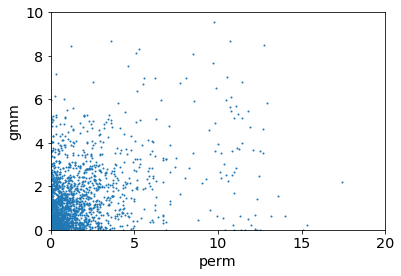

In [109]:
plt.scatter(-np.log(perm_dv_pvals), -np.log(gmm_dv_pvals), s=1)
plt.xlabel('perm');plt.ylabel('gmm');
plt.xlim(0, 20);
plt.ylim(0, 10);

In [93]:
(estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['dv_fdr'] < 0.2).sum()

270

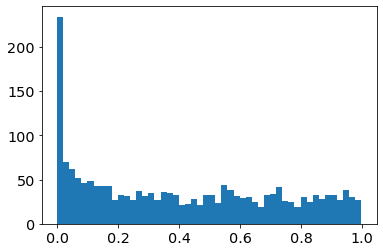

In [85]:
plt.hist(estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['dv_pval'], bins=50);

In [88]:
def fdrcorrect(pvals):
	"""
		Perform FDR correction with nan's.
	"""

	fdr = np.ones(pvals.shape[0])
	_, fdr[~np.isnan(pvals)] = fdrcorrection(pvals[~np.isnan(pvals)])
	return fdr

In [89]:
dv_fdr = fdrcorrect(gmm_dv_pvals)

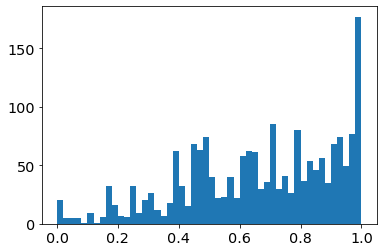

In [91]:
plt.hist(dv_fdr, bins=50);

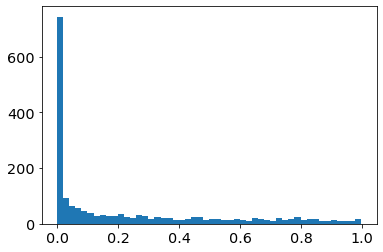

In [77]:
plt.hist(gmm_de_pvals, bins=50);